# Applying LPDiD and LPDiDPois to Synthetic Datasets

This notebook demonstrates the application of both `LPDiD` and `LPDiDPois` functions to our synthetic datasets. We'll apply:
- `LPDiD` with `swap_pre_diff=False` (standard OLS approach)
- `LPDiDPois` with `swap_pre_diff=True` (recommended for Poisson to avoid negative values)

We'll visualize results using event plots with a consistent window of -5 to 5 periods around treatment.

In [20]:
# Which python version is this?
import sys
if sys.version_info < (3, 6):
    print("This script requires Python 3.6 or higher.")
    sys.exit(1)

# Print version
print("Python version:", sys.version)

Python version: 3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]


In [21]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add the parent directory to path to import LPDiD package
sys.path.append('..')
from LPDiD.lpdid import LPDiD, LPDiDPois

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Loading the Synthetic Datasets

First, let's load the synthetic datasets we generated earlier. These datasets contain outcomes from treatment effects of varying magnitudes.

In [22]:
# Define the path to synthetic datasets
data_dir = './synth_data'

# List available datasets
datasets = {}
for file in os.listdir(data_dir):
    if file.endswith('.csv') and file.startswith('synth_data_'):
        name = file.replace('synth_data_', '').replace('.csv', '')
        datasets[name] = pd.read_csv(os.path.join(data_dir, file))
        
print(f"Loaded {len(datasets)} synthetic datasets:")
for name, data in datasets.items():
    print(f"  - {name}: {data.shape[0]} observations, {data['i'].nunique()} individuals, {data['t'].nunique()} time periods")

Loaded 7 synthetic datasets:
  - high_treatment_effect: 100000 observations, 5000 individuals, 20 time periods
  - similar_groups: 100000 observations, 5000 individuals, 20 time periods
  - small_sample: 20000 observations, 1000 individuals, 20 time periods
  - baseline: 100000 observations, 5000 individuals, 20 time periods
  - early_treatment: 100000 observations, 5000 individuals, 20 time periods
  - negative_effect: 100000 observations, 5000 individuals, 20 time periods
  - long_horizon: 150000 observations, 5000 individuals, 30 time periods


## Exploring a Dataset

Let's explore the structure of one dataset to understand what we're working with.

In [23]:
# Look at the baseline dataset
baseline_data = datasets['baseline']
print("First few rows:")
baseline_data.head()

First few rows:


,i,t,group,Y,Y_counterfactual,treated
0,0,1,1,0,0,0
1,0,2,1,0,0,0
2,0,3,1,0,1,0
3,0,4,1,0,1,0
4,0,5,1,0,1,0


In [24]:
# Summary statistics
baseline_data.describe()

,i,t,group,Y,Y_counterfactual,treated
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2499.500000,10.50000,1.500000,0.591720,0.57724,0.250000
std,1443.382861,5.76631,0.500003,0.491518,0.49400,0.433015
min,0.000000,1.00000,1.000000,0.000000,0.00000,0.000000
25%,1249.750000,5.75000,1.000000,0.000000,0.00000,0.000000
50%,2499.500000,10.50000,1.500000,1.000000,1.00000,0.000000
75%,3749.250000,15.25000,2.000000,1.000000,1.00000,0.250000
max,4999.000000,20.00000,2.000000,1.000000,1.00000,1.000000


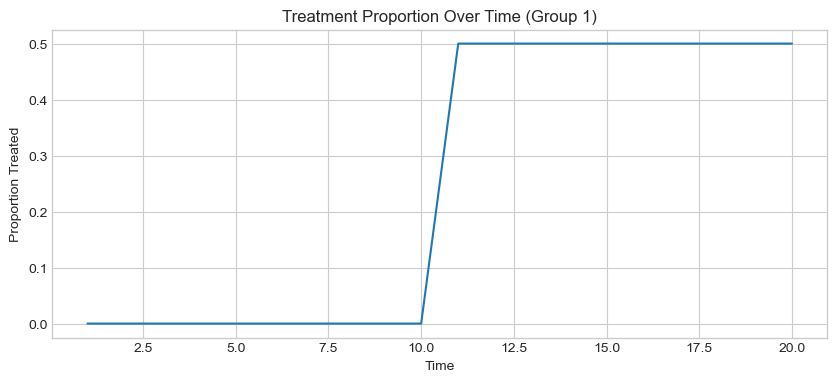

In [25]:
# Check for treatment timing
treatment_by_time = baseline_data.groupby('t')['treated'].mean()
plt.figure(figsize=(10, 4))
plt.plot(treatment_by_time.index, treatment_by_time.values)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Proportion Treated')
plt.title('Treatment Proportion Over Time (Group 1)')
plt.show()

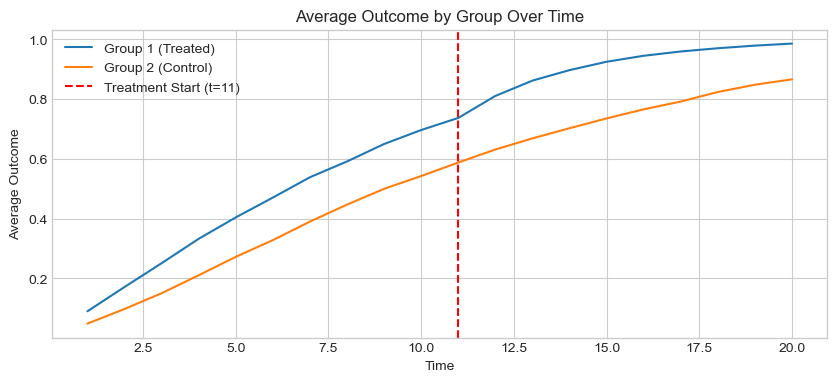

In [26]:
# Look at average outcomes by group over time
outcomes_by_group_time = baseline_data.groupby(['t', 'group'])['Y'].mean().unstack()
plt.figure(figsize=(10, 4))
plt.plot(outcomes_by_group_time.index, outcomes_by_group_time[1], label='Group 1 (Treated)')
plt.plot(outcomes_by_group_time.index, outcomes_by_group_time[2], label='Group 2 (Control)')
# Find treatment start time
t_star = int(baseline_data.loc[baseline_data['treated'] == 1, 't'].min())
plt.axvline(x=t_star, color='red', linestyle='--', label=f'Treatment Start (t={t_star})')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Average Outcome')
plt.title('Average Outcome by Group Over Time')
plt.legend()
plt.show()

## Helper Function for Event Study Plots

Let's create a helper function to generate event study plots from our results. We'll standardize to show periods -5 to 5 relative to treatment.

In [27]:
def plot_event_study(results, title=None, ylim=None, xlabel='Periods Relative to Treatment', ylabel='Coefficient', window=(-5, 5)):
    """Create event study plot from LPDiD results with a standardized window.
    
    Parameters:
    -----------
    results : LPDiDResults
        Results object from LPDiD or LPDiDPois
    title : str, optional
        Plot title
    ylim : tuple, optional
        Y-axis limits (min, max)
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    window : tuple
        Analysis window for x-axis (min_horizon, max_horizon)
    """
    event_df = results.event_study.copy()
    
    # Filter to the requested window
    min_h, max_h = window
    event_df = event_df[(event_df['horizon'] >= min_h) & (event_df['horizon'] <= max_h)]
    
    plt.figure(figsize=(12, 6))
    
    # Plot point estimates
    plt.plot(event_df['horizon'], event_df['coefficient'], 'o-', color='blue', label='Coefficient')
    
    # Plot confidence intervals
    plt.fill_between(
        event_df['horizon'], 
        event_df['ci_low'], 
        event_df['ci_high'], 
        color='blue', 
        alpha=0.2, 
        label='95% CI'
    )
    
    # Add reference line at y=0
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Add vertical line at treatment time (horizon=0)
    plt.axvline(x=0, color='red', linestyle='--')
    
    # Set plot labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Set x-axis ticks to integers within our window
    plt.xticks(range(min_h, max_h + 1))
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Event Study: {results.depvar}')
    
    if ylim:
        plt.ylim(ylim)
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return event_df

## Applying LPDiD and LPDiDPois to the Baseline Dataset

Let's apply the models to our baseline dataset:
1. LPDiD with swap_pre_diff=False (standard for OLS)
2. LPDiDPois with swap_pre_diff=True (better for Poisson to avoid negative values)

In [ ]:
# Apply LPDiD with swap_pre_diff=False (standard for OLS)
lpdid_baseline = LPDiD(
    data=baseline_data,
    depvar='Y',
    unit='i',
    time='t',
    treat='treated',
    pre_window=10,  # Look at 10 pre-treatment periods
    post_window=9,  # Look at 9 post-treatment periods
    formula='~ | t',  # Only time fixed effects
    cluster_formula='~ i',  # Cluster at individual level
    swap_pre_diff=False,  # Standard setting for OLS
    n_jobs=8,
    lean = True,
    copy_data=True
)

# Fit the model
results_lpdid = lpdid_baseline.fit()

print(results_lpdid)

# # Plot results with standardized window of -5 to 5
# plot_event_study(results_lpdid, title="LPDiD (OLS with swap_pre_diff=False)", window=(-5, 5))


LP-DiD Initialization (Linear Model)

Model Information:
  Model type: Linear regression (OLS)
  Dependent variable: Y
  Unit identifier: i
  Time identifier: t
  Treatment indicator: treated
  Pre-treatment window: 10
  Post-treatment window: 9

Parallel Processing Configuration:
  System: Darwin arm64
  Available CPU cores: 16
  Cores to be used: 8
  Total regressions to run: 19
  Multiprocessing start method: spawn
Fixed effects: t
Clustering variables: i

Preparing data...
Data preparation complete. Dataset has 100000 observations.

Starting LP-DiD Estimation (Linear Model)

Step 1: Identifying clean control samples...
Clean control identification complete.

Step 2: Generating long differences...
Generating long differences for 19 horizons...
Using optimized vectorized approach
